#Collaborative Filtering

Collaborative filtering is a popular technique used in recommendation systems to provide personalized recommendations to users. It is based on the idea that people who have agreed in the past tend to agree again in the future. In other words, it leverages the collective behavior of users to make recommendations.

 The idea is that if User A and User B have similar tastes on certain issues, then User A is likely to have similar opinions as User B on other issues.


There are two main types of collaborative filtering:

1. Neighborhood-Based Collaborative Filtering:
Neighborhood-based collaborative filtering relies on the idea of similarity, either between users or between items, to make recommendations. It's a memory-based approach that directly uses historical user-item interaction data.

 * User-Based Collaborative Filtering: This method focuses on finding users who are similar to the target user based on their past interactions (e.g., ratings, purchases). Recommendations are made by identifying items liked by similar users but not yet encountered by the target user.

 * Item-Based Collaborative Filtering: In this approach, items are correlated based on user interactions(ratings). Recommendations are made by suggesting items that are similar to those the user has already shown interest in. This method relies on the similarity between items rather than users.


 2. Model-Based Collaborative Filtering:
 Model-based collaborative filtering, as the name suggests, builds predictive models using machine learning or mathematical techniques. These models are trained on historical user-item interaction data to understand the underlying relationships between users and items.Model-based collaborative filtering can handle large datasets and may perform better in situations with sparse data. It offers more flexibility in capturing intricate patterns in user preferences but requires more computational resources for training and can be sensitive to overfitting.

 Some common model-based techniques include:

    * Matrix Factorization: Decomposing the user-item interaction matrix into lower-dimensional matrices, which can be used to predict missing values (unseen interactions).

    * Singular Value Decomposition (SVD): A matrix factorization method used for dimensionality reduction and recommendation.

    * Deep Learning-Based Models: Neural networks can be used to capture complex patterns in user-item interactions, providing highly accurate recommendations.

 Both neighborhood-based and model-based collaborative filtering have their strengths and weaknesses. Some recommendation systems use a hybrid approach, combining elements of both methods to leverage the advantages of each and mitigate their respective limitations. The choice between these methods depends on the specific application, available data, and computational resources.

 In this notebook, we will focus on implementing user-based collaborative filtering as a form of neighborhood-based collaborative filtering.

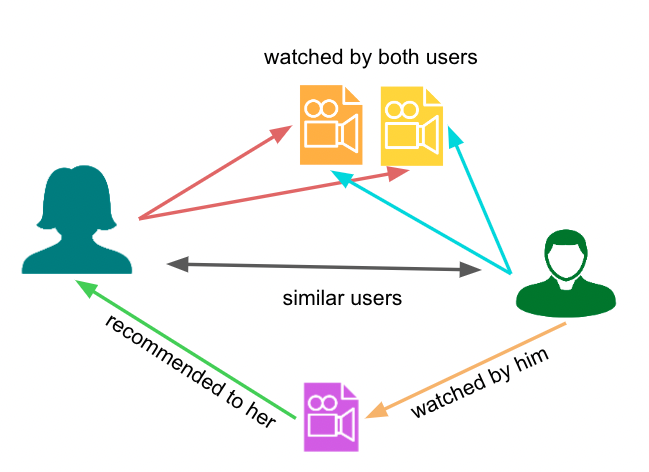



### Similarity Metrics

In the context of **neighborhood-based** collaborative filtering, it's crucial to comprehend how to gauge the similarity between users or items.

There are several methods to measure the similarity between two vectors (which could represent two users or two items). This notebook specifically explores two metrics used for vector comparison:

* **Pearson's Correlation Coefficient**

Pearson's correlation coefficient quantifies the strength and direction of a linear relationship. The coefficient ranges from -1 to 1, where -1 signifies a strong negative linear relationship and 1 signifies a strong positive linear relationship.

Given two vectors x and y, their correlation can be defined as:

$$CORR(x, y) = \frac{\text{COV}(x, y)}{\text{STDEV}(x)\text{ }\text{STDEV}(y)}$$

where

$$\text{STDEV}(x) = \sqrt{\frac{1}{n-1}\sum_{i=1}^{n}(x_i - \bar{x})^2}$$

and

$$\text{COV}(x, y) = \frac{1}{n-1}\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})$$

Here, n is the length of the vector (which must be identical for both x and y), and $\bar{x}$ is the mean of the vector's observations. The correlation coefficient can indicate how similar two vectors are; the closer the coefficient is to 1, the more similar the vectors are. However, there are potential drawbacks to using this metric as a similarity measure.

* **Euclidean Distance**

Euclidean distance measures the straight-line distance between two vectors. As a distance measure, larger values indicate that two vectors are more dissimilar (which contrasts with Pearson's correlation coefficient).

The Euclidean distance between two vectors x and y is calculated as:

$$ \text{EUCL}(x, y) = \sqrt{\sum_{i=1}^{n}(x_i - y_i)^2}$$

Unlike the correlation coefficient, no scaling is performed in the denominator. Hence, it's essential to ensure all your data are on the same scale when using this metric.

**Note:** Since similarity measurement often involves examining the distance between vectors, it's important to scale your data or ensure all data are on the same scale. If some measures are on a 5-point scale while others are on a 100-point scale, you may encounter suboptimal results due to feature variability. In this case, scaling isn't necessary because all data are on a 10-point scale. However, it's always important to consider!


##Import necessary libraries & Load the datasets

In [ ]:
# Import necessary libraries
import numpy as np  # Import NumPy for numerical operations
import pandas as pd  # Import Pandas for data manipulation and analysis
import matplotlib.pyplot as plt  # Import Matplotlib for data visualization
from itertools import combinations
# Enable inline plotting for Jupyter notebooks
%matplotlib inline

In [ ]:
# Read in the datasets
movies = pd.read_csv('/content/drive/MyDrive/movies_clean.csv')
reviews = pd.read_csv('/content/drive/MyDrive/reviews_clean.csv')
del movies['Unnamed: 0']
del reviews['Unnamed: 0']


In [135]:
#Display first five rows
reviews.head()


,user_id,movie_id,rating,timestamp,date,month_1,month_2,month_3,month_4,month_5,...,month_9,month_10,month_11,month_12,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
0,1,68646,10,1381620027,2013-10-12 23:20:27,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1,1,113277,10,1379466669,2013-09-18 01:11:09,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,2,422720,8,1412178746,2014-10-01 15:52:26,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,2,454876,8,1394818630,2014-03-14 17:37:10,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,2,790636,7,1389963947,2014-01-17 13:05:47,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


### User-Item Matrix
To compute similarities, it’s common practice to arrange values in a matrix. In this matrix, each row represents a user, and each column represents an item.


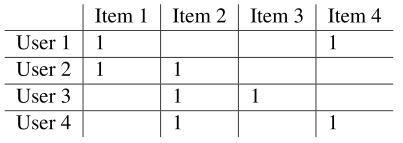

Initially, we need to generate the user-item matrix using the reviews dataset, with the actual ratings serving as its values.

In [ ]:
# Selecting relevant columns 'user_id', 'movie_id', and 'rating' from the 'reviews' dataset
user_items = reviews[['user_id', 'movie_id', 'rating']]

# Checking the shape of the resulting 'user_items' DataFrame
user_items.shape


(712337, 3)

In [ ]:
# display
user_items.head()

,user_id,movie_id,rating
0,1,68646,10
1,1,113277,10
2,2,422720,8
3,2,454876,8
4,2,790636,7


To expedite the calculation of similarities and to avoid a memory error, let's extract a sample from the 'user_items' dataset, considering that the original dataset is quite large.

In [ ]:
# Randomly selecting a sample of 10000 rows from the 'user_items' DataFrame
sampled_user_items = user_items.sample(100000)


In [ ]:
# Creating the User-Item Matrix:
# Using the 'pivot' function to pivot the 'sampled_user_items' DataFrame, with 'user_id' as the index (rows),
# 'movie_id' as the columns, and 'rating' as the values, resulting in a User-Item Matrix.
user_movie_matrix = sampled_user_items.pivot(index='user_id', columns='movie_id', values='rating')


In [ ]:
#display
user_movie_matrix.head()

movie_id,417,2101,2354,3740,4099,6206,6864,7162,7264,7880,...,7897478,7923374,7938790,7967954,7983794,8079546,8088944,8140564,8144868,8289196
user_id,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Checking the shape
user_movie_matrix.shape

(22223, 12801)

Now that we have a matrix of users by movies, we will use this matrix to create a dictionary where the key is each user and the value is an array of the movies each user has rated.

In [ ]:
def movies_watched(user_id):
    '''
    INPUT:
    user_id - the user_id of an individual as int
    user_item_matrix - a DataFrame representing the user-item matrix

    OUTPUT:
    movies - an array of movies the user has watched
    '''

    # Check if the user_id exists in the user_item_matrix
    if user_id in user_movie_matrix.index:
        # Get the row corresponding to the user and filter out non-null values
        movies = user_movie_matrix.loc[user_id].dropna().index.tolist()
    else:
        # If the user_id is not found, return an empty list
        movies = []

    return movies


In [ ]:
#the user ID for which we want to find the watched movies
user_id_to_test = 35288

# Call the function 'movies_watched' to get the list of movies watched by the user
# The function takes two arguments: the user ID and the user-movie matrix
movies_watched_by_user = movies_watched(user_id_to_test)

# Print the result
print(f"Movies watched by User {user_id_to_test}:")
# Print the list of movies watched by the user
print(movies_watched_by_user)


Movies watched by User 35288:
[25316, 34583, 51378, 52357, 55928, 56193, 56937, 57345, 58085, 58150, 59800, 59885, 61809, 63522, 69762, 70328, 70735, 71562, 73636, 74751, 76666, 77416, 77631, 78718, 85496, 89360, 89370, 89560, 90264, 93058, 93142, 94155, 95159, 95647, 96336, 98206, 98635, 98724, 99653, 99785, 100802, 101410, 101605, 102316, 103776, 104438, 104815, 107206, 107315, 107808, 109254, 109303, 109635, 110074, 111257, 111742, 112722, 113071, 113243, 115857, 115862, 116287, 116353, 116930, 118647, 118715, 118749, 119051, 119141, 119164, 119173, 119217, 120008, 120382, 120633, 120879, 124298, 126859, 133093, 143145, 147800, 154420, 160127, 161081, 163978, 164912, 170691, 171580, 181852, 201485, 203019, 216216, 221889, 234215, 237572, 246460, 256380, 266465, 269347, 274309, 280486, 280590, 283900, 288477, 289848, 309593, 311113, 325123, 330539, 333766, 337631, 338751, 340163, 342492, 344510, 346491, 348505, 355295, 359950, 361620, 365957, 368711, 369610, 371746, 373469, 374345, 3

In [ ]:
def create_user_movie_dict():
    '''
    INPUT:
    user_movie_matrix - a DataFrame representing the user-item matrix
    OUTPUT:
    movies_seen - a dictionary where each key is a user_id and the value is an array of movie_ids

    Creates the movies_seen dictionary using the movies_watched function
    '''

    # Initialize an empty dictionary to store the results
    movies_seen = {}

    # Iterate through the user IDs in the user-item matrix
    for user in user_movie_matrix.index:
        # Initialize an empty list for the user's movie IDs
        movies_seen[user] = []

        # Call the movies_watched function to get the list of movie IDs watched by the user
        movie_list = movies_watched(user)

        # Extend the user's list of movie IDs with the results from movies_watched
        movies_seen[user].extend(movie_list)

    # Return the movies_seen dictionary
    return movies_seen


In [ ]:
movies_seen = create_user_movie_dict()

# Print the result for a specific user ID
user_id_to_test = 2
print(f"Movies watched by User {user_id_to_test}:")
print(movies_seen.get(user_id_to_test, []))


Movies watched by User 2:
[1433811]


If a user hasn't rated more than 2 movies, we consider these users "too new".

In [ ]:
# Remove individuals who have watched 2 or fewer movies - don't have enough data to make recs
def create_movies_to_analyze(movies_seen, lower_bound=2):
    '''
    INPUT:
    movies_seen - a dictionary where each key is a user_id and the value is an array of movie_ids
    lower_bound - an integer, a user must have more movies seen than or equal to the lower_bound to be added to the movies_to_analyze dictionary

    OUTPUT:
    movies_to_analyze - a dictionary where each key is a user_id and the value is an array of movie_ids

    The movies_seen and movies_to_analyze dictionaries should be the same except that the output dictionary has removed users with movies seen less than the specified lower_bound.
    '''

    # Create an updated dictionary that filters out users with movies seen less than the lower_bound
    movies_to_analyze = {k: v for k, v in movies_seen.items() if len(v) > lower_bound}

    return movies_to_analyze


In [ ]:
# call the function with a lower_bound value of 2
movies_to_analyze = create_movies_to_analyze(movies_seen)

# Print the result
print("Movies to Analyze:")
print(movies_to_analyze)




Movies to Analyze:
{31: [3315342, 5027774, 6316138], 33: [1340138, 1502712, 2395427], 44: [93137, 108399, 116282, 1043844, 1124035, 1234719, 2582846], 51: [42004, 44706, 57590, 1024648, 1195478, 2023587, 2278388], 54: [80684, 94737, 137523, 455944, 470752, 1229340, 1285016, 1306980, 1800246, 2582846, 2788710, 3460252], 55: [54215, 99077, 108399, 376541, 765010, 1306980, 1595656, 1638002, 1655441, 2034031, 2042568, 2267998], 66: [38854, 39757, 48316, 55277, 63442, 68555, 97123, 115736, 120889, 125659, 138704, 317248, 353969, 361862, 427312, 499335, 816442, 1033575, 1441395, 1486834, 1520888, 1559036, 1619029, 1756750, 1791682, 1798709, 1951181, 2035630, 2084989, 2139843, 2278388, 2278871, 2390361, 2458912, 2582782, 3244512, 3263614, 3503460, 3553442, 3612616, 3704700, 4196450, 4594834, 5462602, 5715874, 6265828], 75: [1646971, 2015381, 2975578], 79: [420223, 2180411, 3302706, 5052448], 90: [181689, 758774, 948470, 1071875, 1355644, 1524137, 1535108, 1611224, 1631867, 1674784, 1684233, 1

####Calculating User Similarities

Now that we have set up the movies_to_analyze dictionary, it is time to take a closer look at the similarities between users.

In [ ]:
def compute_correlation(user1, user2):
    '''
    INPUT
    user1 - int user_id
    user2 - int user_id
    OUTPUT
    the correlation between the matching ratings between the two users
    '''
    movies_user1=movies_to_analyze[user1]
    movies_user2=movies_to_analyze[user2]
    common_movies = np.intersect1d(movies_user1,movies_user2,assume_unique=True)
    corr=user_movie_matrix.loc[[user1,user2],common_movies].T.corr()
    return corr #return the correlation

In [ ]:
compute_correlation(35288,10481)

user_id,35288,10481
user_id,,
35288,1.000000,0.525122
10481,0.525122,1.000000


In [ ]:
compute_correlation(2,104)

,2,104
user_id,,
2,1.0,NaN
104,NaN,1.0


 users 2 and 104 have a correlation of NaN. Why?

In [ ]:
movies_user1=movies_to_analyze[2]
movies_user2=movies_to_analyze[104]
np.intersect1d(movies_user1,movies_user2,assume_unique=True)

movie_id,454876,1454468,1535109,816711
user_id,,,,
2,8.0,8.0,8.0,8.0
104,9.0,7.0,9.0,7.0


This occurs because of zero variance, where the ratings given by a user for all the common movies are identical. In these cases, the correlation calculation entails division by zero, leading to the generation of NaN values.

Instead, calculate the Euclidean distance between the ratings.

In [ ]:
def compute_euclidean_dist(user1, user2):
    '''
    INPUT
    user1 - int user_id
    user2 - int user_id
    OUTPUT
    the euclidean distance between user1 and user2
    '''
    # Get the ratings of user1 and user2 for common movies
    movies1=movies_to_analyze[user1]
    movies2 = movies_to_analyze[user2]
    # Find common movies rated by both users
    common_movies=np.intersect1d(movies1,movies2,assume_unique=True)
    if len(common_movies) == 0:
      return 0  # No common movies, distance is 0
    df = user_movie_matrix.loc[[user1,user2],common_movies]
    # Calculate the Euclidean distance
    dist = np.linalg.norm(df.loc[user1]- df.loc[user2],ord=2)

    return dist #return the euclidean distance

In [ ]:
# Test cases
user1 = 2
user2 = 104
user3 = 5  # An arbitrary user with no common movies with user1

# Calculate Euclidean distance between user1 and user2
distance_1_2 = compute_euclidean_dist(user1, user2)
print(f"Euclidean distance between user {user1} and user {user2}: {distance_1_2}")

Euclidean distance between user 2 and user 104: 2


#### Calculate Euclidean distance between each user and every other user.

In [ ]:
# Create an empty list to store the results
euclidean_dists = []

# Get the keys as a list for easier indexing
users = list(movies_to_analyze.keys())

# Generate combinations of pairs of users
user_combinations = combinations(users, 2)

# Iterate over all pairs of users in movies_to_analyze
for user1, user2 in user_combinations:
    # Compute Euclidean distance between the pair of users
    dist = compute_euclidean_dist(user1, user2)

    # If dist is not NaN (i.e., the users have at least one movie in common), add to list
    if not np.isnan(dist):
        euclidean_dists.append({'User1': user1, 'User2': user2, 'Euclidean_Distance': dist})

# Convert list to DataFrame
euclidean_dists = pd.DataFrame(euclidean_dists)

In [ ]:
euclidean_dists.head()

,user1,user2,eucl_dist
0,2,2,0.000000
1,2,66,2.236068
2,2,90,5.385165
3,2,99,2.828427
4,2,104,2.000000


#### Make Recommendations

We have a measure of distance between each user and every other user. This dataframe holds every possible pairing of users, as well as the corresponding euclidean distance.

we will find the users that are 'nearest' each user.

In [122]:
def find_closest_neighbors(user):
    '''
    INPUT:
        user - (int) the user_id of the individual you want to find the closest users
    OUTPUT:
        closest_neighbors - an array of the id's of the users sorted from closest to farthest away
    '''
    # Filter the DataFrame to get rows where 'user1' is equal to the given user ID
    # Sort the filtered DataFrame by the 'eucl_dist'
    closest_neighbors= np.array(euclidean_dists[euclidean_dists["user1"]==user].sort_values(by="eucl_dist").iloc[1:]['user2'])
    return closest_neighbors

In [123]:
# find the closest neighbors to user 2
find_closest_neighbors(2)

array([  755, 22915, 35310, ..., 36807, 32494, 52737])

In [129]:
def movies_liked(user_id, min_rating=7):
    '''
    INPUT:
    user_id - the user_id of an individual as int
    min_rating - the minimum rating considered while still a movie is still a "like" and not a "dislike"
    OUTPUT:
    movies_liked - an array of movies the user has watched and liked
    '''
    movies_liked= np.array(sampled_user_items[(sampled_user_items["user_id"]==user_id)&(sampled_user_items["rating"]> min_rating)]["movie_id"])

    return movies_liked

In [130]:
# test the function movies_liked
movies_liked(2)

array([2361509, 1433811, 2726560, 1454468])

In [99]:
def movie_names(movie_ids):
    '''
    INPUT
    movie_ids - a list of movie_ids
    OUTPUT
    movies - a list of movie names associated with the movie_ids

    '''
    # Filter the 'movies' DataFrame to select rows where 'movie_id' is in the given list
    # Then, retrieve the 'movie' column values for the filtered rows
    movie_lst = list(movies[movies["movie_id"].isin(movie_ids)]["movie"])

    return movie_lst

In [101]:
# test the function movie_names
movie_ids = [10,1798709,68646]
m_names = movie_names(movie_ids)
m_names

['La sortie des usines Lumière (1895)', 'The Godfather (1972)', 'Her (2013)']

In [109]:
def make_recommendations(user, num_recs=10):
    '''
    INPUT:
        user - (int) a user_id of the individual you want to make recommendations for
        num_recs - (int) number of movies to return
    OUTPUT:
        recommendations - a list of movies - if there are "num_recs" recommendations return this many
                          otherwise return the total number of recommendations available for the "user"
                          which may just be an empty list
    '''
    # Find the closest neighbors for the user
    closest_neighbors = find_closest_neighbors(user)

    # Get movies already seen by the user
    user_movies_seen = movies_watched(user)

    # Create an empty set to store unique movie recommendations
    recommendations = set()

    # Iterate through closest neighbors and recommend movies they've highly rated but the user hasn't seen
    for neighbor in closest_neighbors:
        neighbor_movies_highly_rated = movies_liked(neighbor)
        recommended_movies = set(neighbor_movies_highly_rated) - set(user_movies_seen)

        # Add recommended movies to the set
        recommendations.update(recommended_movies)

        # Check if we have enough recommendations
        if len(recommendations) >= num_recs:
            break

    # Convert the set back to a list and limit the recommendations to the specified number
    recommendations = list(recommendations)[:num_recs]
    # Convert movie IDs to movie names
    recommended_movie_names = movie_names(recommendations)

    return recommended_movie_names


In [133]:
# Test the make_recommendations function
user_id = 33
recommendations = make_recommendations(user_id, num_recs=10)
print("Recommendations for User", user_id, ":")
print(recommendations)

Recommendations for User 33 :
['A State of Mind (2004)', '21 (2008)', 'Deadpool (2016)', 'The Big Short (2015)', 'The Maze Runner (2014)', 'The Hunger Games: Catching Fire (2013)', 'Inside Out (2015)', 'Kingsman: The Secret Service (2014)', 'Dohee-ya (2014)', 'Hush (2016)']


In [134]:
# Test the make_recommendations function
user_id = 2
recommendations = make_recommendations(user_id, num_recs=3)
print("Recommendations for User", user_id, ":")
print(recommendations)

Recommendations for User 2 :
['Gotcha! (1985)', 'Jack Reacher (2012)', 'Le moine (2011)']


In [114]:
def all_recommendations(num_recs=10):
    '''
    INPUT
        num_recs (int) the (max) number of recommendations for each user
    OUTPUT
        all_recs - a dictionary where each key is a user_id and the value is an array of recommended movie titles
    '''

    all_recs = {}

    # Get a list of all user IDs
    all_users = list(user_movie_matrix.index)

    for user_id in all_users:
        recommendations = make_recommendations(user_id, num_recs)
        all_recs[user_id] = recommendations

    return all_recs


In [115]:
#test recommendation function
all_recs = all_recommendations(num_recs=10)


In [139]:
len(all_recs.keys())

23512

In [140]:
#print the first key-value pair in the all_recs dictionary
first_key = next(iter(all_recs))
print("User ID:", first_key)
print("Recommendations:", all_recs[first_key])


User ID: 2
Recommendations: ['Philadelphia (1993)', 'Training Day (2001)', 'About Schmidt (2002)', 'Insomnia (2002)', 'The United States of Leland (2003)', 'Shattered Glass (2003)', 'Man on Fire (2004)', 'Flipped (2010)', 'Silver Linings Playbook (2012)', 'Lawless (2012)', '50/50 (2011)', 'Crazy, Stupid, Love. (2011)', 'The Perks of Being a Wallflower (2012)', 'Before I Go to Sleep (2014)', 'Zero Dark Thirty (2012)', 'American Hustle (2013)', 'Django Unchained (2012)', 'Side Effects (2013)', 'Gone Girl (2014)', 'Enough Said (2013)', 'Nightcrawler (2014)']
